In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
# import pymc3 as pm
import seaborn as sns
import wtascripts.wta_helpers as wta_helpers

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'png'
# mpl.rcParams['figure.dpi']= 300

# import warnings
# warnings.simplefilter('ignore')

In [2]:
# Sklearn specific imports
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MultiLabelBinarizer, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
plt.rcParams['figure.figsize'] = (8,5)

## Helper Functions

In [4]:
def residual_plot(y_pred, y_train, title=None):
    res = y_train - y_pred
    plt.scatter(y_pred, res, s=3)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    if title:
        plt.title(title)
    return plt
#     plt.show()
#     return result

In [5]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(12,5))
    
#     s = x.shape[0]
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

### Preprocessing

In [6]:
# Load then clean dataset
df = wta_helpers.load_raw_df()
df = wta_helpers.clean_raw_df(df, minvotes=4)

In [7]:
# Create 

# df = df[df.countreports > 0]
# df['log_countreports'] = np.log(df['countreports'])
# df['log_votes'] = np.log(df['votes'])

In [8]:
onehot_feats = ['Wildflowers/Meadows', 'Ridges/passes',
'Wildlife','Waterfalls','Old growth','Summits','Good for kids','Dogs allowed on leash',
'Fall foliage','Lakes','Rivers','Coast','Mountain views','Established campsites',]
# Not used: lat, long, subregion, lengthtype


#cont_feats = ['votes', 'countreports', 'length', 'gain', 'hpoint']

# use below if doing log of countreports and votes
# cont_feats = ['votes', 'countreports', 'length', 'gain', 'hpoint', 'log_countreports', 'log_votes']


cont_feats = ['countreports', 'length', 'gain', 'hpoint']


# cont_feats = ['votes', 'length', 'gain', 'hpoint']
# cont_feats = ['length', 'gain', 'hpoint']

oh_cols = df[onehot_feats]

#Standardize the non one-hot encoding variables into XS
s = StandardScaler()
XS = s.fit_transform(df[cont_feats])
#print(oh_cols)
# combine with the one hot encoding variables

# multilabelbinarizer for 'fees' column
mlb = MultiLabelBinarizer()
fees_processed = mlb.fit_transform(df['fee'].str.replace(", ",",").str.split(","))

# labelbinarizer for 'region' column
lb = LabelBinarizer()
region_processed = lb.fit_transform(df['region'])

X = np.concatenate([XS, oh_cols, fees_processed, region_processed], axis=1) ## All features
# X = np.concatenate([oh_cols, fees_processed, region_processed], axis=1) ## Remove continuous features
# X = np.concatenate([XS], axis=1) ## Only continuous features

y = df['rating'] # SEE BELOW - I NOW MADE y and X OFF A PANDAS DATAFRAME

# This code makes a DF of my transformed variables. There is some weird stuff in there with neg lengths...
y2 = y[:,np.newaxis]
XSpecial = np.concatenate([X, y2], axis=1)
df_model = pd.DataFrame(XSpecial, columns= (cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) + ['rating']))

y = df_model['rating']
X = df_model.drop('rating',axis=1)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Tips from Chad on what I can do now:
* Plot whatever feats I want to explore vs residuals
* Look for patterns in data
* If I am missing data in a certain area of my predicted vs actual plots, then take subset and look there
* plot sum /log / function of the categorical features, vs residuals.

##### Once I find a pattern and want to Feat Eng., then add a new column to my X data array.

In [9]:
# Who is our audience for Project 2? Recruiters? classmates?
### How do you recommend showing model? Need coefficients. Just "say" how well it did on a few?

### Should I graph out MSE test vs train to help me decide on polynomial degrees? I already know 2 is better
### than 3 or 1

# Graphs probably look good in presentation.

# Test Train Split

In [10]:
#pprint.pprint(coefs)

In [11]:
# # New training based on excluding variables that a LassoCV zeroed out
# X_lassoed = X.drop(columns=['length','gain','hpoint','Dogs allowed on leash', 'Established campsites', 'National Monument Fee',
#       'None','Refuge Entrance Pass', 'Central Washington','Eastern Washington', 'North Cascades',
#       'Snoqualmie Region', 'Southwest Washington'])

# # second Lasso to weed out more

# X_again = X_lassoed.drop(columns=['Central Cascades', 'Northwest Forest Pass','Rivers'])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

In [13]:
## Reduced features due to lasso
# X_train, X_test, y_train, y_test = train_test_split(X_lassoed, y)

In [14]:
## Reduced features FOR THE 2ND TIME due to lasso
# X_train, X_test, y_train, y_test = train_test_split(X_again, y)

### Test Suite

In [15]:
alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,10,100]

# lr = LinearRegression()
# lr.fit(X_train, y_train)
# print("LinReg - Poly 1")
# print("Train R^2:", lr.score(X_train, y_train))
# print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
# print("")

# poly_lr = make_pipeline(PolynomialFeatures(2), LinearRegression())
# # cross_validate(poly_lr, X_train, y=y_train)
# poly_lr.fit(X_train, y_train)
# print("LinReg - Poly 2")
# print("Train R^2:", poly_lr.score(X_train, y_train))
# print("Train MSE:", metrics.mean_squared_error(y_train, poly_lr.predict(X_train)))
# print("")

# lasso = LassoCV(cv=5, alphas=alphas)
# lasso.fit(X_train, y_train)
# print("LassoCV - Poly 1")
# print("Train R^2:", lasso.score(X_train, y_train))
# print("Train MSE:", metrics.mean_squared_error(y_train, lasso.predict(X_train)))
# print("")

poly_lasso = make_pipeline(PolynomialFeatures(2), LassoCV(cv=5, alphas=alphas))
poly_lasso.fit(X_train, y_train)
print("LassoCV - Poly 2")
print("Train R^2:", poly_lasso.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_lasso.predict(X_train)))

print("")

##### Save these for final model evaluation!
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_lasso.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_lasso.predict(X_test)))
print('Test R^2: ', poly_lasso.score(X_test, y_test))
print("alpha used:", poly_lasso.get_params()['lassocv'].alpha_)


# ridge = RidgeCV(cv=5)
# ridge.fit(X_train, y_train)
# print("RR - Poly 1")
# print("Train R^2:", ridge.score(X_train, y_train))
# print("Train MSE:", metrics.mean_squared_error(y_train, ridge.predict(X_train)))
# print("")

poly_ridge = make_pipeline(PolynomialFeatures(2), RidgeCV(cv=5, alphas=alphas))
poly_ridge.fit(X_train, y_train)
print("RR - Poly 2")
print("Train R^2:", poly_ridge.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_ridge.predict(X_train)))
print("")
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_ridge.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_ridge.predict(X_test)))
print('Test R^2: ', poly_ridge.score(X_test, y_test))

print("")
print("alpha used:", poly_ridge.get_params()['ridgecv'].alpha_)


poly_elastic = make_pipeline(PolynomialFeatures(2), ElasticNetCV(l1_ratio=0.1, cv=5, alphas=alphas))
poly_elastic.fit(X_train, y_train)
print("RR - Poly 2")
print("Train R^2:", poly_elastic.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_elastic.predict(X_train)))
print("")
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_elastic.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_elastic.predict(X_test)))
print('Test R^2: ', poly_elastic.score(X_test, y_test))

print("")
print("alpha used:", poly_elastic.get_params()['elasticnetcv'].alpha_)


/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

LassoCV - Poly 2
Train R^2: 0.2852163418570681
Train MSE: 0.3264419317996743

Test RMSE: 0.5817381104253544
Test MSE: 0.3384192291212618
Test R^2:  0.20047175372819181
alpha used: 0.01


/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.879916e-17
  overwrite_a=False)
/home/spe

RR - Poly 2
Train R^2: 0.3678721404469316
Train MSE: 0.2886930013943232

Test RMSE: 0.5812185494805799
Test MSE: 0.33781500226030936
Test R^2:  0.20189926257200663

alpha used: 100.0


/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

RR - Poly 2
Train R^2: 0.2595868818523146
Train MSE: 0.33814691461457413

Test RMSE: 0.5810292325162482
Test MSE: 0.33759496903842034
Test R^2:  0.20241909939237668

alpha used: 0.1


/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [16]:
alphas

[1e-14, 1e-10, 1e-06, 0.001, 0.01, 0.1, 1, 10, 100]

In [17]:
poly_elastic = make_pipeline(PolynomialFeatures(2), ElasticNetCV(l1_ratio=0.1, cv=5, alphas=alphas, 
                                                                 max_iter=8000))
poly_elastic.fit(X_train, y_train)
print("RR - Poly 2")
print("Train R^2:", poly_elastic.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_elastic.predict(X_train)))
print("")
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_elastic.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_elastic.predict(X_test)))
print('Test R^2: ', poly_elastic.score(X_test, y_test))

print("")
print("alpha used:", poly_elastic.get_params()['elasticnetcv'].alpha_)


/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

RR - Poly 2
Train R^2: 0.2595868818523146
Train MSE: 0.33814691461457413

Test RMSE: 0.5810292325162482
Test MSE: 0.33759496903842034
Test R^2:  0.20241909939237668

alpha used: 0.1


/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [123]:
alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,10,100]

# lr = LinearRegression()
# lr.fit(X_train, y_train)
# print("LinReg - Poly 1")
# print("Train R^2:", lr.score(X_train, y_train))
# print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
# print("")

# poly_lr = make_pipeline(PolynomialFeatures(2), LinearRegression())
# # cross_validate(poly_lr, X_train, y=y_train)
# poly_lr.fit(X_train, y_train)
# print("LinReg - Poly 2")
# print("Train R^2:", poly_lr.score(X_train, y_train))
# print("Train MSE:", metrics.mean_squared_error(y_train, poly_lr.predict(X_train)))
# print("")

# lasso = LassoCV(cv=5, alphas=alphas)
# lasso.fit(X_train, y_train)
# print("LassoCV - Poly 1")
# print("Train R^2:", lasso.score(X_train, y_train))
# print("Train MSE:", metrics.mean_squared_error(y_train, lasso.predict(X_train)))
# print("")

poly_lasso = make_pipeline(PolynomialFeatures(2, interaction_only=True), LassoCV(cv=5, alphas=alphas))
poly_lasso.fit(X_train, y_train)
print("LassoCV - Poly 2")
print("Train R^2:", poly_lasso.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_lasso.predict(X_train)))

print("")

##### Save these for final model evaluation!
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_lasso.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_lasso.predict(X_test)))
print('Test R^2: ', poly_lasso.score(X_test, y_test))
print("alpha used:", poly_lasso.get_params()['lassocv'].alpha_)


# ridge = RidgeCV(cv=5)
# ridge.fit(X_train, y_train)
# print("RR - Poly 1")
# print("Train R^2:", ridge.score(X_train, y_train))
# print("Train MSE:", metrics.mean_squared_error(y_train, ridge.predict(X_train)))
# print("")

poly_ridge = make_pipeline(PolynomialFeatures(2, interaction_only=True), RidgeCV(cv=5, alphas=alphas))
poly_ridge.fit(X_train, y_train)
print("RR - Poly 2")
print("Train R^2:", poly_ridge.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_ridge.predict(X_train)))
print("")
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_ridge.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_ridge.predict(X_test)))
print('Test R^2: ', poly_ridge.score(X_test, y_test))

print("")
print("alpha used:", poly_ridge.get_params()['ridgecv'].alpha_)


poly_elastic = make_pipeline(PolynomialFeatures(2, interaction_only=True), ElasticNetCV(l1_ratio=0.1, cv=5, alphas=alphas))
poly_elastic.fit(X_train, y_train)
print("RR - Poly 2")
print("Train R^2:", poly_elastic.score(X_train, y_train))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_elastic.predict(X_train)))
print("")
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_elastic.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_elastic.predict(X_test)))
print('Test R^2: ', poly_elastic.score(X_test, y_test))

print("")
print("alpha used:", poly_elastic.get_params()['elasticnetcv'].alpha_)


/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

LassoCV - Poly 2
Train R^2: 0.2782050086397735
Train MSE: 0.32146364946805206

Test RMSE: 0.6109410805773783
Test MSE: 0.3732490039370547
Test R^2:  0.18147096230664295
alpha used: 0.01


/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWa

RR - Poly 2
Train R^2: 0.32511177547854897
Train MSE: 0.30057292477027653

Test RMSE: 0.6138122603929206
Test MSE: 0.3767654910086666
Test R^2:  0.17375936294957406

alpha used: 100.0


/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

RR - Poly 2
Train R^2: 0.2760227672543675
Train MSE: 0.32243554770532146

Test RMSE: 0.610230826742127
Test MSE: 0.37238166190637983
Test R^2:  0.18337302937241073

alpha used: 0.1


/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

# Linear Regression

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)

print("intercept:",lr.intercept_)
# print("coefficients,",lr.coef_)

y_pred_tr = lr.predict(X_train)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_tr)))
print("Train MSE:", metrics.mean_squared_error(y_train, y_pred_tr))
print("Train R^2:", lr.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))z

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(lr.coef_,3)), key=lambda x: x[1], reverse=True))

intercept: 3.5484089535988073
Train RMSE: 0.5851137357350953
Train MSE: 0.34235808374587895
Train R^2: 0.25036602330593194




In [20]:
"""Polynomial with LinearRegression"""

poly_lr = make_pipeline(PolynomialFeatures(2), LinearRegression())
poly_lr.fit(X_train, y_train)

y_pred_tr = poly_lr.predict(X_train)


print("Train RMSE:", np.sqrt(mean_squared_error(y_train, poly_lr.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_lr.predict(X_train)))
print("Train R^2:", poly_lr.score(X_train, y_train))
print("")


y_pred_test = poly_lr.predict(X_test)

##### Save these for final model evaluation!
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("Test MSE:", mean_squared_error(y_test, y_pred_test))
print('Test R^2: ', poly_lr.score(X_test, y_test))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(poly_lr.coef_,3)), key=lambda x: x[1], reverse=True))

Train RMSE: 0.38788941052659315
Train MSE: 0.15045819479866793
Train R^2: 0.6705537849170362

Test RMSE: 863021475.7094227
Test MSE: 7.448060675356698e+17
Test R^2:  -1.7596325437406505e+18



<module 'matplotlib.pyplot' from '/home/spencer/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

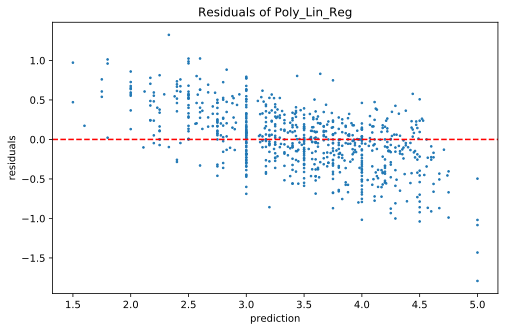

In [21]:
# plot of poly_lr
residual_plot(y_train, poly_lr.predict(X_train), "Residuals of Poly_Lin_Reg")

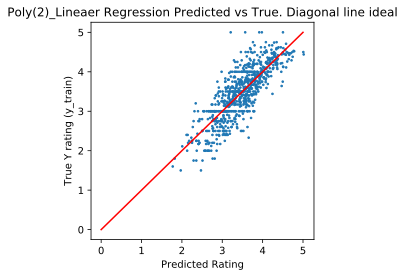

In [22]:
plt.figure(figsize=(4,4))
plt.scatter(poly_lr.predict(X_train), y_train, s=3)
plt.xlabel("Predicted Rating")
plt.ylabel("True Y rating (y_train)")
plt.title("Poly(2)_Lineaer Regression Predicted vs True. Diagonal line ideal")
plt.plot(range(6), c='r');

# Lasso

In [23]:
#alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,10,100]
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)
print("intercept:",lasso.intercept_)
# print("coefficients,",lasso.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lasso.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, lasso.predict(X_train)))
print("Train R^2:", lasso.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(lasso.coef_,3)), key=lambda x: x[1], reverse=True))

intercept: 3.244355053840742
Train RMSE: 0.590950838215091
Train MSE: 0.3492228931871186
Train R^2: 0.23533470187669073




In [24]:
"""Polynomial with LassoCV"""

alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,100]
poly_lasso = make_pipeline(PolynomialFeatures(2, interaction_only=True), LassoCV(cv=3, alphas=alphas))
poly_lasso.fit(X_train, y_train)
#print("intercept:",poly_lasso.intercept_)
# print("coefficients,",poly_lasso.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, poly_lasso.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_lasso.predict(X_train)))
print("Train R^2:", poly_lasso.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_lasso.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_lasso.predict(X_test)))
print('Test R^2: ', poly_lasso.score(X_test, y_test))

print("")

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did no

Train RMSE: 0.5793540356629211
Train MSE: 0.3356510986389133
Train R^2: 0.26505176947658327

Test RMSE: 0.5873550655213777
Test MSE: 0.34498597299362194
Test R^2:  0.1849575726173336



/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [25]:
# simple_lasso= LassoCV(cv=3)
# simple_lasso.fit(X_train, y_train)

In [26]:
# coefs_list = X.columns
# # newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# # newlist = cont_feats ## only continuous features
# import pprint
# coefs = sorted(zip(coefs_list, np.round(simple_lasso.coef_,3)), key=lambda x: x[1], reverse=True)
# pprint.pprint(coefs)

In [27]:
# coefs

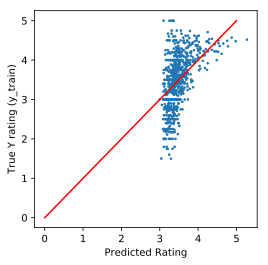

In [28]:
plt.figure(figsize=(4,4))
plt.scatter(poly_lasso.predict(X_train), y_train, s=3)
plt.xlabel("Predicted Rating")
plt.ylabel("True Y rating (y_train)")
plt.plot(range(6), c='r');

# Ridge Regression

In [29]:
#Straight Ridge Regression

#alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,100]
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
print("intercept:",ridge.intercept_)
# print("coefficients,",ridge.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, ridge.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, ridge.predict(X_train)))
print("Train R^2:", ridge.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Test MSE:", metrics.mean_squared_error(y_test, y_pred))
# print('Test R^2: ', est.score(X_test, y_test))

print("")

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(ridge.coef_,3)), key=lambda x: x[1], reverse=True))

intercept: 3.255170055498748
Train RMSE: 0.5865225212305624
Train MSE: 0.34400866791065554
Train R^2: 0.24675187183688663




In [30]:
"""Polynomial with RidgeCV"""

alphas = [1e-14,1e-10,1e-6,1e-3,1e-2,1e-1,1,100]
poly_ridge = make_pipeline(PolynomialFeatures(2, interaction_only=True), RidgeCV(cv=3, alphas=alphas))
poly_ridge.fit(X_train, y_train)
#print("intercept:",poly_ridge.intercept_)
# print("coefficients,",poly_ridge.coef_)

print("Train RMSE:", np.sqrt(mean_squared_error(y_train, poly_ridge.predict(X_train))))
print("Train MSE:", metrics.mean_squared_error(y_train, poly_ridge.predict(X_train)))
print("Train R^2:", poly_ridge.score(X_train, y_train))
print("")

##### Save these for final model evaluation!
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, poly_ridge.predict(X_test))))
print("Test MSE:", metrics.mean_squared_error(y_test, poly_ridge.predict(X_test)))
print('Test R^2: ', poly_ridge.score(X_test, y_test))

print("")
print("alpha used:", poly_ridge.get_params()['ridgecv'].alpha_)

#coefs_list = cont_feats + onehot_feats + list(mlb.classes_) + list(lb.classes_) ## Everything
# newlist = onehot_feats + list(mlb.classes_) + list(lb.classes_) ## remove continuous features
# newlist = cont_feats ## only continuous features
#pprint.pprint(sorted(zip(coefs_list, np.round(poly_ridge.coef_,3)), key=lambda x: x[1], reverse=True))

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:167: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.708044e-17
  overwrite_a=False)
/home/spe

Train RMSE: 0.5450681189211329
Train MSE: 0.2970992542642223
Train R^2: 0.34946564424561544

Test RMSE: 0.5969263762307844
Test MSE: 0.356321098640016
Test R^2:  0.15817790896505143

alpha used: 100.0


/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


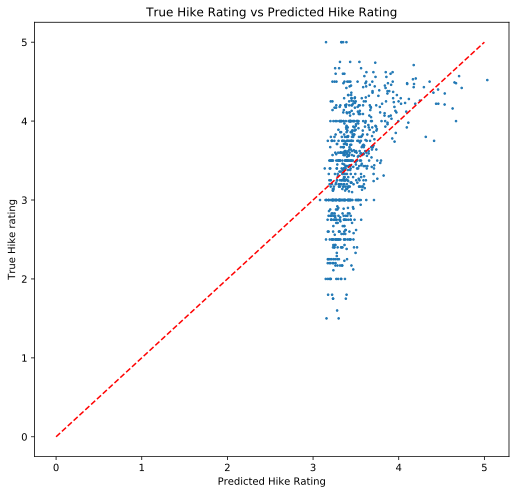

In [31]:
plt.figure(figsize=(11,8))
plt.scatter(poly_elastic.predict(X_train), y_train, s=3)
plt.xlabel("Predicted Hike Rating")
plt.ylabel("True Hike rating")
plt.title("True Hike Rating vs Predicted Hike Rating")
plt.plot(range(6), c='r', ls="--")
plt.subplots_adjust(left=0.3)
plt.savefig('predicted_v_actual.svg', transparent=True)

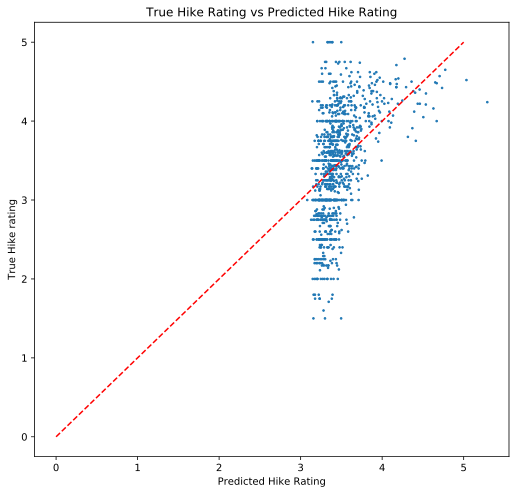

In [32]:
plt.figure(figsize=(11,8))
plt.scatter(poly_elastic.predict(X), y, s=3)
plt.xlabel("Predicted Hike Rating")
plt.ylabel("True Hike rating")
plt.title("True Hike Rating vs Predicted Hike Rating")
plt.plot(range(6), c='r', ls="--")
plt.subplots_adjust(left=0.3)
plt.savefig('predicted_v_actual.svg', transparent=True)

In [33]:
# residual_plot(y_train, poly_ridge.predict(X_train))

# Feature Engineering and EDA

# Plots

In [34]:
# sns.pairplot(df_model, y_vars = 'rating', x_vars = df_model.columns[:-1]);

In [35]:
# sns.pairplot(df_model, y_vars = 'rating', x_vars = cont_feats);

In [36]:
# sns.pairplot(df, y_vars = 'rating', x_vars= cont_feats);

In [37]:
# hike_bar = df[onehot_feats].sum().sort_values().plot.barh(title="Number of hikes with feature", color='navy').get_figure()
# hike_bar.subplots_adjust(left=0.3)
# hike_bar.savefig('hike_bar.svg', transparent=True)

In [38]:
# heatmap = sns.heatmap(X.corr())
# fig = heatmap.get_figure()
# #fig.figure(figsize=(6,6))
# fig.set_size_inches(8,5)
# fig.subplots_adjust(left=0.3, bottom=0.3)
# fig.savefig('correlation_heatmap.svg', transparent=True);

In [39]:
# # plot of poly_lr
# fig = residual_plot(y_train, poly_elastic.predict(X_train), "Residuals of ElasticNet - Poly(2)")
# # fig = fig.get_figure()
# fig.subplots_adjust(left=0.3, bottom=0.2)
# fig.savefig('residuals_elasticnet_2.svg', transparent=True);

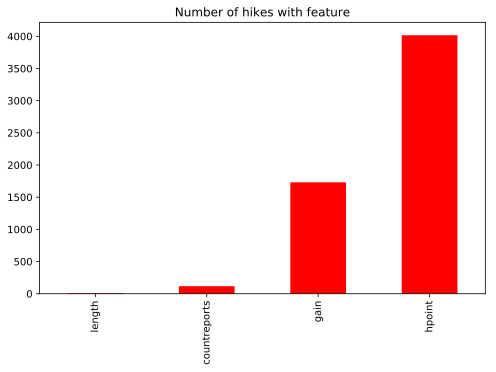

In [40]:
(df[cont_feats].mean()
                .sort_values()
                .plot.bar(title="Number of hikes with feature", color='red')
                
)

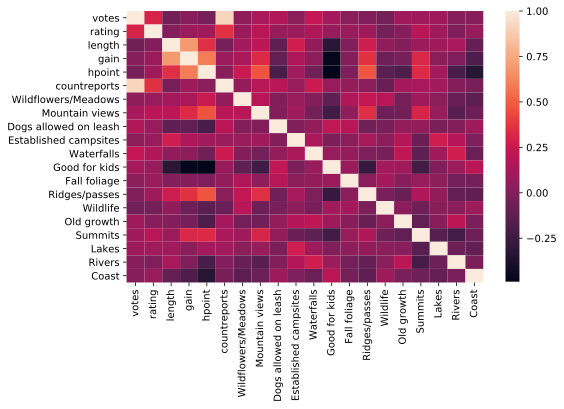

In [41]:
sns.heatmap(df.corr())

TypeError: unhashable type: 'numpy.ndarray'

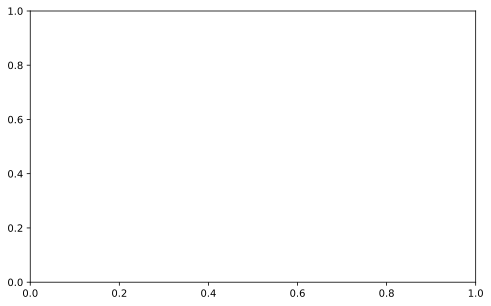

In [42]:
plt.plot(df)

In [ ]:
# votes, count of tripreports, mountains, waterfall, summits, then hpoint, then ridges/passes

In [ ]:
# sns.pairplot(df[(df.votes > 3) & (df.length < 60) & (df.hpoint < 9000)],
#              x_vars=['votes','length','gain','hpoint','countreports'],
#              y_vars='rating')

In [ ]:
# # votes and count reports are highly correlated
# plt.scatter(df['votes'], df['countreports']);

# Doing sanity test / Experimental Work with Tranformations and Random Forest Regression


Text(0,0.5,'actual')

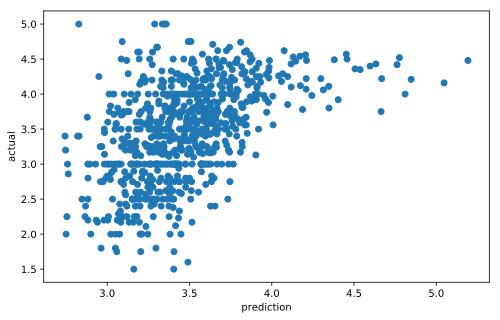

In [43]:
from sklearn.linear_model import Ridge, Lasso

lm = Ridge()

lm.fit(X_train, y_train)
plt.scatter(lm.predict(X_train), y_train)
plt.xlabel('prediction')
plt.ylabel('actual')

In [44]:
lm.intercept_

3.359397116102388

In [45]:
X_train

,countreports,length,gain,hpoint,Wildflowers/Meadows,Ridges/passes,Wildlife,Waterfalls,Old growth,Summits,Good for kids,Dogs allowed on leash,Fall foliage,Lakes,Rivers,Coast,Mountain views,Established campsites,Discover Pass,National Monument Fee,National Park Pass,None,Northwest Forest Pass,Refuge Entrance Pass,Sno-Parks Permit,Central Cascades,Central Washington,Eastern Washington,Issaquah Alps,Mount Rainier Area,North Cascades,Olympic Peninsula,Puget Sound and Islands,Snoqualmie Region,South Cascades,Southwest Washington
969,-0.538,-0.188,-1.021,-1.383,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
513,-0.324,0.567,1.013,-0.123,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
563,-0.065,0.342,0.356,0.726,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
612,-0.553,-0.188,-1.021,0.497,1.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
63,0.256,0.474,0.982,0.979,1.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
11,-0.334,-0.162,1.107,0.680,1.000,1.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
374,-0.589,-0.453,-0.708,-0.283,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
964,-0.466,-0.056,0.669,0.520,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
871,-0.085,1.785,1.295,1.001,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
782,-0.578,-1.036,-1.033,-1.205,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000


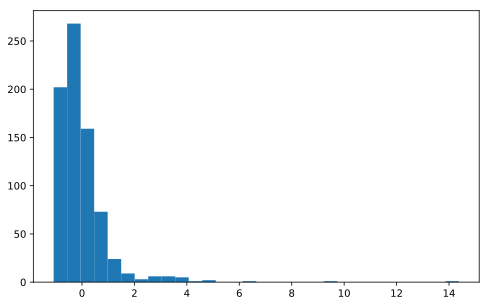

In [46]:
plt.hist(X_train['length'], bins=30);

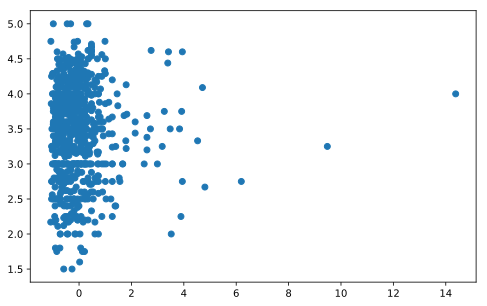

In [47]:
plt.scatter(X_train['length'], y_train)

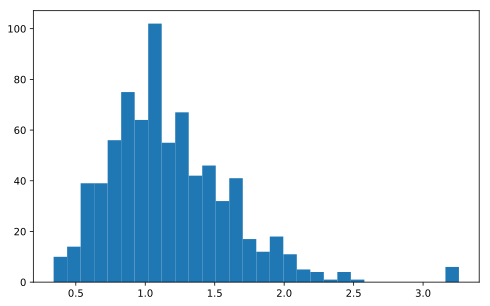

In [105]:
z_train = np.log(5.2/(5.2-y_train))
plt.hist(z_train, bins = 30);

In [61]:
df.shape

(1015, 24)

In [69]:
cols_to_use = ['countreports', 'length', 'gain', 'hpoint'] + list(df.columns[10:])

In [70]:
cols_to_use

['countreports',
 'length',
 'gain',
 'hpoint',
 'Wildflowers/Meadows',
 'Mountain views',
 'Dogs allowed on leash',
 'Established campsites',
 'Waterfalls',
 'Good for kids',
 'Fall foliage',
 'Ridges/passes',
 'Wildlife',
 'Old growth',
 'Summits',
 'Lakes',
 'Rivers',
 'Coast']

In [71]:
mock_df = df.copy()[cols_to_use]

In [76]:
mock_df['log_count'] = np.log1p(mock_df.countreports)
mock_df['log_length'] = np.log1p(mock_df.length)
mock_df['log_gain'] = np.log1p(mock_df.gain)
mock_df['log_hpoint'] = np.log1p(mock_df.hpoint)

In [79]:
mock_df = mock_df.drop(['countreports', 'length', 'gain', 'hpoint'], axis=1)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


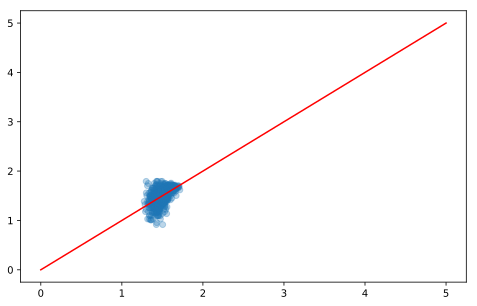

In [118]:
ssX = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(mock_df, df['rating'])

X_train_scaled = ssX.fit_transform(X_train)
z_train = np.log(5.2/(5.2-y_train))

lm = RidgeCV(alphas=[1e-3, 1e-1, 1, 10])
lm.fit(X_train_scaled, np.log1p(y_train))
plt.scatter(lm.predict(X_train_scaled), np.log1p(y_train), alpha=0.3)
plt.plot([0,5], [0,5], 'r-')

In [119]:
y_predict =np.exp(lm.predict(X_train_scaled))

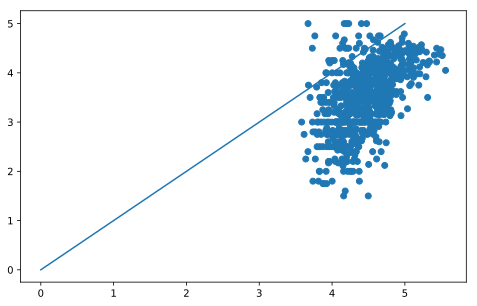

In [120]:
plt.scatter(y_predict, y_train)
plt.plot([0,5],[0,5])

In [88]:
mock_df.columns[-5:]

Index(['Coast', 'log_count', 'log_length', 'log_gain', 'log_hpoint'], dtype='object')

In [91]:
X_train['Coast'].sum()

36

In [92]:
X_train.shape

(761, 18)

In [94]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train, y_train)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

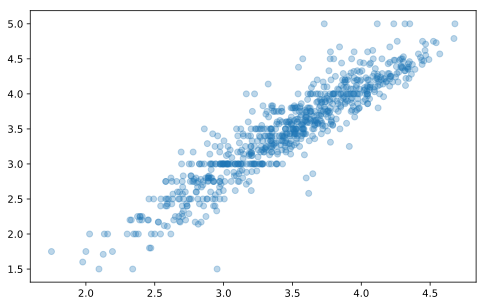

In [95]:
plt.scatter(rf.predict(X_train), y_train, alpha=0.3)

In [99]:
X_train.columns[np.argsort(rf.feature_importances_)[::-1]]

Index(['log_count', 'log_hpoint', 'log_length', 'log_gain', 'Summits', 'Lakes',
       'Mountain views', 'Fall foliage', 'Rivers', 'Wildflowers/Meadows',
       'Old growth', 'Waterfalls', 'Good for kids', 'Dogs allowed on leash',
       'Coast', 'Ridges/passes', 'Wildlife', 'Established campsites'],
      dtype='object')

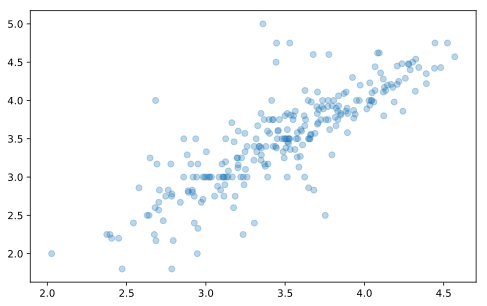

In [117]:
plt.scatter(rf.predict(X_test), y_test, alpha=0.3)

In [121]:
metrics.r2_score(rf.predict(X_test), y_test)

0.4160598443838591

In [122]:
metrics.r2_score(rf.predict(X_train), y_train)

0.4510848469465516